In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy
import math
from matplotlib import animation
import scipy.linalg
%matplotlib notebook

# x = np.linspace(-40,40,200)
# plt.plot(x, U_exact(x,0,1,5))

def ddf(x,sig):
    val = np.zeros_like(x)
    val[(-(1/(2*sig))<=x) & (x<=(1/(2*sig)))] = 1
    return val


dir0 = 0.0  
dir1 = 0.0  
#  function for setting initial conditions in space

def I(x,sig): # initial u(x,0)
    M = np.size(x)
    i_x = ddf(x,sig)
    k = np.zeros_like(x)
    return i_x

def U_exact(x,t,sig,v,D):
    M = np.size(x)
    u_ex = np.zeros(M)
    if t == 0:
        u_ex = ddf(x,sig)
    else:
        y = x - v*t
        u_ex = np.exp(-y**2/(4*t*D))/np.sqrt(4*np.pi*t*D)
        u_ex[0] = dir0
        u_ex[M-1] = dir1
    return u_ex


def U_sol(Nt_gaps,T,Nx_spaces,L,v,I,sig,D):

    Nt_points = Nt_gaps + 1

    t = np.linspace(0.,T,Nt_points)  # times at each time step
    Nx_points = Nx_spaces + 1 
    x = np.linspace(-L, L, Nx_points)
    x_pde = np.linspace(-L, L, Nx_points)    # mesh points in space
    dx = x_pde[1] - x_pde[0] 
    dt = t[1] - t[0]

    # Setting B, C and v for the numerical soultions
    C = D*dt/(dx**2)
    B = v*dt/(dx*2)
    u   = np.zeros(Nx_points)
    u_old = np.zeros(Nx_points)
    U = np.zeros((Nx_points,Nt_points))
    U_ex = np.zeros((Nx_points, Nt_points))

    # Data structures for the linear system
    A = np.zeros((Nx_points, Nx_points))
    b = np.zeros(Nx_points)

    for i in range(1, Nx_points-1):
        A[i,i-1] = -D*C-B
        A[i,i+1] = -D*C+B
        A[i,i] = 1 + 2*D*C

    # set the dirichlet conditions
    A[0,0] = 0
    A[Nx_points-1,Nx_points-1] = 0
    # find the inverse of A which doesn't change

    # Set initial condition u(x,0) = I(x)
    u_old[:] = I(x[:],sig)

    # initialise matrices for storing solutions
    U[:,0] = u_old[:]
    U_ex[:,0] = U_exact(x,0,sig,v,D)

    # do timestepping 
    for n in range(1, Nt_points):
        # Compute b and solve linear system
        b[1:Nx_points-2] = u_old[1: Nx_points-2]
        b[0] = dir0;  b[Nx_points-1] = dir1

        # update u by calculating A_inverse . b
        u_new = scipy.sparse.linalg.spsolve(A,b)
        # Update u_1 before next step
        u_old = u_new
        U[:,n] = u_new
        U_ex[:,n] = U_exact(x,t[n],sig,v,D)
        
    return U

def plotting(U,L,sig,T,Nt_gaps,Nx_spaces, v,D):
    size_t = np.size(U,1)-1 # number of time steps
    t = np.linspace(0.,T,Nt_gaps-1)
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    markers =['X','.','+','o']

    colours = ['r','c','b','orange','m'] # make comparison easy
    colour_pos = 0;
    x_pde = np.linspace(-L, L, Nx_spaces+1)
    N_dots = 20
    x_dots = np.linspace(-L, L, N_dots+1)    # spacial points to plot exact solution at

# some arbitarily chosen time points to compare at
    for plot_pos in [0, round(size_t/10), round(size_t/5), round(size_t/2), round(size_t-2)]:
    # exact solution
        U_tplot = U_exact(x_pde,t[plot_pos],sig,v,D) 
        label = "t=" + "%0.3f" % (round(t[plot_pos]),)
        ax[0].plot(x_pde,U_tplot,color = colours[colour_pos],ls='--', label=label)

    # numerical solution
        label = "t=" + "%0.3f" % (round(t[plot_pos]),)
        ax[1].plot(x_pde,U[:,plot_pos],color = colours[colour_pos],ls='--', label=label)
        colour_pos = colour_pos + 1;
    

    plt.xlim(-L,L) # zoom in on area of interest
    ax[0].legend(loc='upper left',fontsize = 7)
    ax[0].set(xlabel = 'Space (km)', ylabel = 'Concentration (Kg/km^3)', title = 'Exact solution')
    ax[1].legend(loc='upper left',fontsize = 7)
    ax[1].set(xlabel = 'Space (km)', ylabel = 'Concentration (Kg/km^3)', title = 'Numerical solution')
    plt.show()

In [42]:
Nt_gaps,T,Nx_spaces,L,v,I,sig,D = 2000, 70, 500, 10, 0, I, 1,0.24
#T = 10000s, L = 100km,, v=0.0067056km/s = 15mi/h, D= 0.000864km^2/s=0.24cm^2/s 
U_actual = U_sol(Nt_gaps,T,Nx_spaces,L,v,I,sig,D)
print(U_actual)

/Users/mehulkishan/opt/anaconda3/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',
/Users/mehulkishan/opt/anaconda3/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:206: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


[[ 0. nan nan ... nan nan nan]
 [ 0. nan nan ... nan nan nan]
 [ 0. nan nan ... nan nan nan]
 ...
 [ 0. nan nan ... nan nan nan]
 [ 0. nan nan ... nan nan nan]
 [ 0. nan nan ... nan nan nan]]


<IPython.core.display.Javascript object>


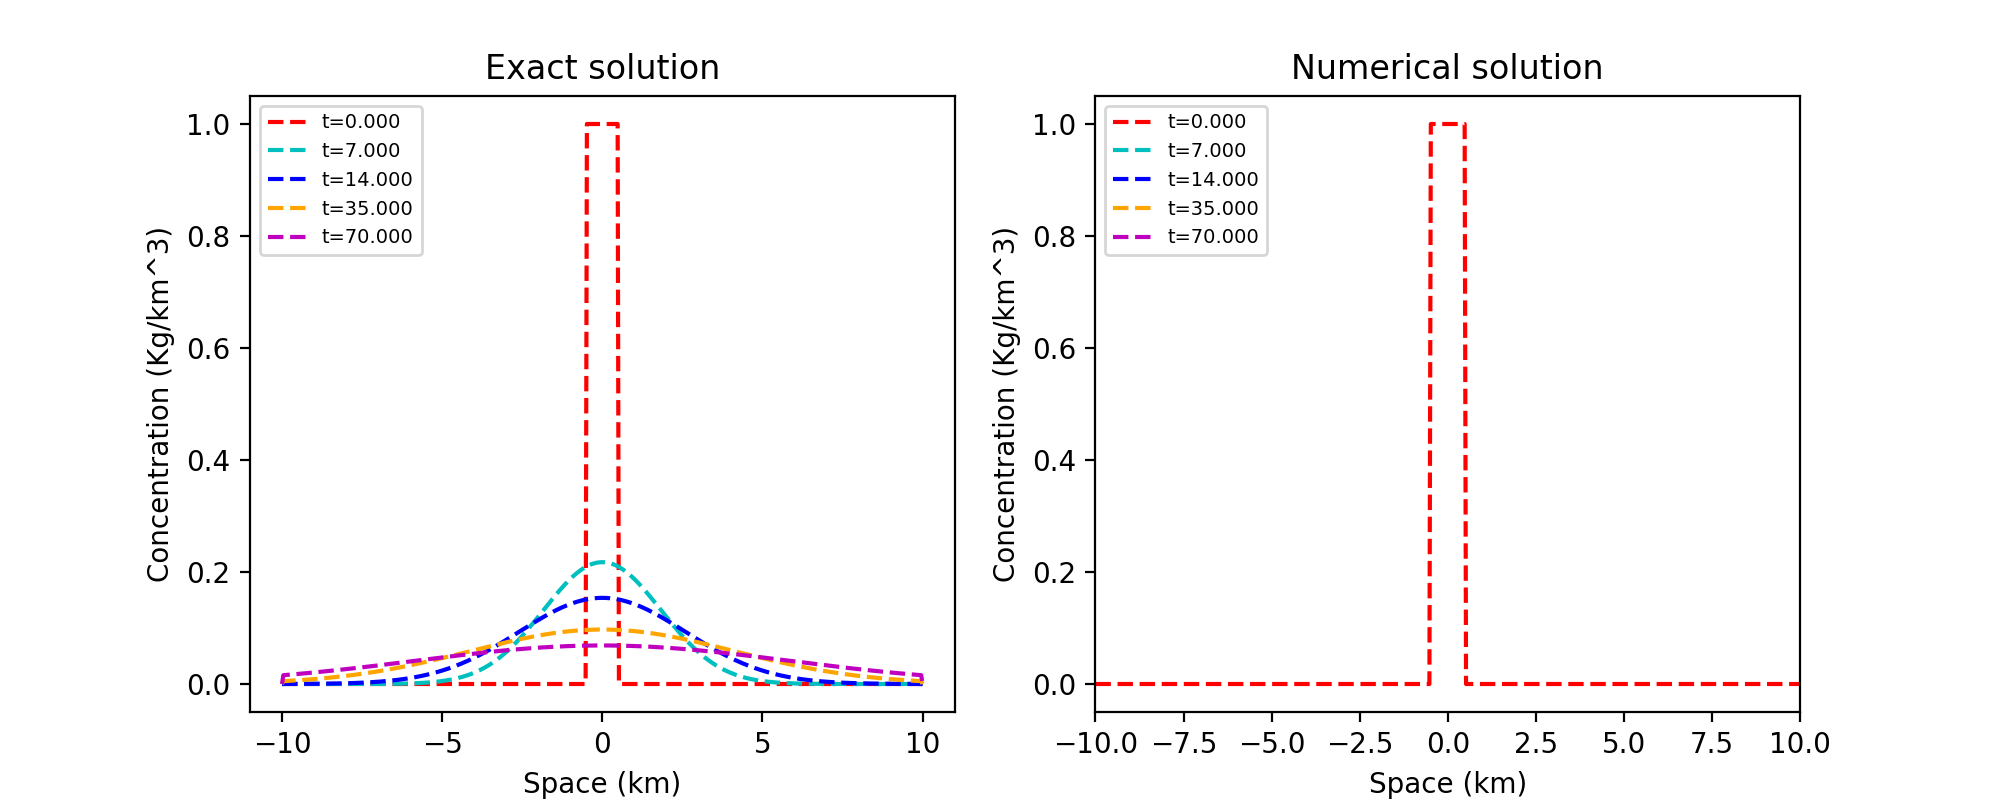

In [43]:
plotting(U_actual,L,sig,T,Nt_gaps,Nx_spaces,v,D)